Шамсутдинов Рустам БВТ2201

Лабораторная работа 2 по сиаод: 

Создать аналог акинатора, определяющий преподавателей и что нас ждёт с ним на сессии

Задаём точки на плоскости методом заполнения квадратичного дерева. С помощью генератора случайных чисел распределяем местоположение точек на плоскости. У каждого объекта свой уникальный номер. Глубина, точность этого дерева, количество объектов - задаётся нами. Нужно визуализировать на координатной плоскости местонахождение этих точек. Далее вбиваем id объекта и выводим всех ближайших соседей.

In [202]:
import random
import matplotlib.pyplot as plt

# Класс для представления точки на плоскости
class Point:
    def __init__(self, x, y, id):
        self.x = x
        self.y = y
        self.id = id

# Класс квадрата, который будет использоваться для деления области
class Rectangle:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

    # Проверяет, содержит ли прямоугольник данную точку
    def contains(self, point):
        return (self.x <= point.x < self.x + self.width and
                self.y <= point.y < self.y + self.height)

    # Проверяет, пересекается ли данный прямоугольник с другим
    def intersects(self, range):
        return not (range.x > self.x + self.width or
                    range.x + range.width < self.x or
                    range.y > self.y + self.height or
                    range.y + range.height < self.y)

# Класс квадратичного дерева
class Quadtree:
    def __init__(self, boundary, capacity):
        self.boundary = boundary  # Прямоугольник, представляющий область
        self.capacity = capacity  # Максимальное количество точек до разделения
        self.points = []          # Список точек в текущем узле
        self.divided = False      # Флаг, указывающий, разделен ли узел

    # Делит узел на 4 подузла
    def subdivide(self):
        x = self.boundary.x
        y = self.boundary.y
        w = self.boundary.width / 2
        h = self.boundary.height / 2

        self.northwest = Quadtree(Rectangle(x, y, w, h), self.capacity)
        self.northeast = Quadtree(Rectangle(x + w, y, w, h), self.capacity)
        self.southwest = Quadtree(Rectangle(x, y + h, w, h), self.capacity)
        self.southeast = Quadtree(Rectangle(x + w, y + h, w, h), self.capacity)

        self.divided = True

    # Добавляет точку в квадратичное дерево
    def insert(self, point):
        if not self.boundary.contains(point):
            return False

        if len(self.points) < self.capacity:
            self.points.append(point)
            return True
        else:
            if not self.divided:
                self.subdivide()

            if self.northwest.insert(point):
                return True
            elif self.northeast.insert(point):
                return True
            elif self.southwest.insert(point):
                return True
            elif self.southeast.insert(point):
                return True

    # Находит все точки в пределах заданного прямоугольника
    def query(self, range, found):
        if not self.boundary.intersects(range):
            return
        else:
            for p in self.points:
                if range.contains(p):
                    found.append(p)
            if self.divided:
                self.northwest.query(range, found)
                self.northeast.query(range, found)
                self.southwest.query(range, found)
                self.southeast.query(range, found)

# Вспомогательная функция для поиска ближайших соседей
def find_neighbors(tree, point, radius):
    search_area = Rectangle(point.x - radius, point.y - radius, radius * 2, radius * 2)
    neighbors = []
    tree.query(search_area, neighbors)
    return neighbors


In [203]:
# Генерация случайных точек на плоскости
def generate_random_points(num_points, width, height):
    points = []
    for i in range(num_points):
        x = random.uniform(0, width)
        y = random.uniform(0, height)
        points.append(Point(x, y, i))
    return points


In [204]:
# Визуализация границ квадратичного дерева
def draw_quadtree_boundaries(quadtree):
    if quadtree is None:
        return

    # Рисуем границу текущего узла (прямоугольник)
    rect = plt.Rectangle(
        (quadtree.boundary.x, quadtree.boundary.y),
        quadtree.boundary.width,
        quadtree.boundary.height,
        fill=False,
        edgecolor='blue',
        linestyle='--'
    )
    plt.gca().add_patch(rect)

    # Если узел разделен, рисуем границы для всех дочерних узлов
    if quadtree.divided:
        draw_quadtree_boundaries(quadtree.northwest)
        draw_quadtree_boundaries(quadtree.northeast)
        draw_quadtree_boundaries(quadtree.southwest)
        draw_quadtree_boundaries(quadtree.southeast)

# Визуализация точек на плоскости
def visualize(points, quadtree=None, highlight=None, radius=0):
    plt.figure(figsize=(8, 8))
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    
    # Отображаем все точки
    for point in points:
        plt.scatter(point.x, point.y, s=10, c='blue')
        # Добавляем лейбл для каждой точки
        plt.text(point.x + 0.5, point.y + 0.5, f'{point.id}', fontsize=8)

    # Подсвечиваем выделенную точку и её соседей
    if highlight:

        # Отрисовка области поиска
        search_area = Rectangle(highlight.x - radius, highlight.y - radius, radius * 2, radius * 2)
        search_rect = plt.Rectangle(
            (search_area.x, search_area.y), search_area.width, search_area.height,
            fill=False, edgecolor='orange', linestyle='-', linewidth=2,
        )
        plt.gca().add_patch(search_rect)
        
        neighbors = find_neighbors(quadtree, highlight, radius)
        for neighbor in neighbors:
            plt.scatter(neighbor.x, neighbor.y, s=10, c='orange')
            # Лейблы для соседей
            plt.text(neighbor.x + 0.5, neighbor.y + 0.5, f'{neighbor.id}', fontsize=8, color='orange')

        plt.scatter(highlight.x, highlight.y, s=10, c='red')
        plt.text(highlight.x + 0.5, highlight.y + 0.5, f'{highlight.id}', fontsize=8, color='red')

    # Отображаем границы квадратичного дерева
    if quadtree:
        draw_quadtree_boundaries(quadtree)

    plt.show()



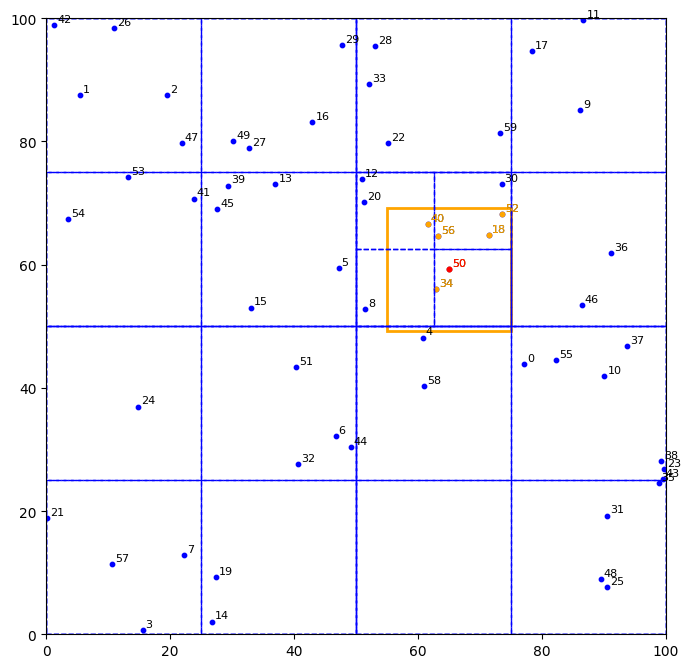

In [205]:
if __name__ == "__main__":
    # Задаем параметры
    width = 100
    height = 100
    num_points = 60
    capacity = 5 # Максимум точек на узел до разделения
    radius = 10 # Радиус поиска точек

    # Создаем границу для дерева
    boundary = Rectangle(0, 0, width, height)

    # Создаем квадратичное дерево
    quadtree = Quadtree(boundary, capacity)

    # Генерируем точки
    points = generate_random_points(num_points, width, height)

    # Вставляем точки в дерево
    for point in points:
        quadtree.insert(point)

    # Выбираем случайную точку для поиска соседей
    selected_point = random.choice(points)

    # Визуализируем точки и выделяем соседей
    visualize(points, quadtree, highlight=selected_point, radius=radius)
